# Fighting Overfitting

Lab created by [Santi Pascual](https://github.com/santi-pdp) and [Xavier Giro-i-Nieto](https://imatge.upc.edu/web/people/xavier-giro) for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2019) and updated by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/) in 2022.

Based on an original version in Keras created by [Miriam Bellver](https://imatge.upc.edu/web/people/miriam-bellver) for the [Barcelona Technology School](https://barcelonatechnologyschool.com/master/master-in-big-data-solutions/) (BTS) in 2018.

### Advice: Select the GPU Hardware Acceleration in the Runtime environment Menu to train the network fast.

We will start replicating the imports, Dataset and training/evaluation routines from the last labs (MLPs and CNNs). Nonetheless, we will work with the [CIFAR-10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains 50.000 training images of 10 classes and 10.000 test images. Does it sound familiar? Yes! MNIST follows a similar structure, but CIFAR contains natural images (planes, dogs, cars, ...) whereas MNIST has quite simplistic patterns that would not allow us to appreciate the challenges that appear when we transfer from training data to evaluation data.

We will refer to evaluation data to the so called validation data. Typically we have two splits during model development and a final split to test it to report results. The former splits are training (obviously) and validation/evaluation. Validation is useful to check how our model performs out of the training corpus. If the model is good at both training and validation, then our model is prone to "generalize" to the test data (real world data). If our model is very good at training and very bad at validation... well you will see later on in this lab the concept... but obviously the model must be changed to get better at validation data as well as training data. Once all this development is done and we match the performance on both splits, we can test the model with data that is non-related at all to the training process.

**NOTE:** in this lab we do not have test data. We consider the CIFAR test split as our validation set to check how model changes affect generalization. Do not let this misguide you. This is just for learning purposes. So we emulate the validation set with the CIFAR test set for convenience only, do not forget.

In [2]:
import time
import random
import numpy as np

import torch
import torch.nn as nn

from random import shuffle
from typing import Tuple, Dict, Any, List
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib

import matplotlib.pyplot as plt

In [3]:
seed = 123
random.seed(seed)
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [4]:
# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [5]:
# Let's define some hyper-parameters
hparams = {
    'batch_size': 100,
    'num_epochs': 12,
    'val_batch_size': 100,
    'num_classes': 10,
    'learning_rate': 1e-3,
    'log_interval': 100,
}

## Defining the training and validation sets

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset initializations

trainset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)

evalset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)

# Pick only the first 10k samples
trainset.data = trainset.data[:10000]
trainset.targets = trainset.targets[:10000]


# Dataloders initialization

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=evalset,
    batch_size=hparams['val_batch_size'],
    shuffle=False,
    drop_last=True,
)

100%|██████████| 170498071/170498071 [00:06<00:00, 27777433.24it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [7]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} RGB images \
({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width \
pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([3, 32, 32])
Label:  6
Batch Img shape:  torch.Size([100, 3, 32, 32])
Batch Label shape:  torch.Size([100])
The Batched tensors return a collection of 100 RGB images (3 channel, 32 height pixels, 32 width pixels)
In the case of the labels, we obtain 100 batched integers, one per image


Let's make a small function to show some CIFAR10 example images. You can see the type of `32x32x3` images we are dealing with.

Files already downloaded and verified


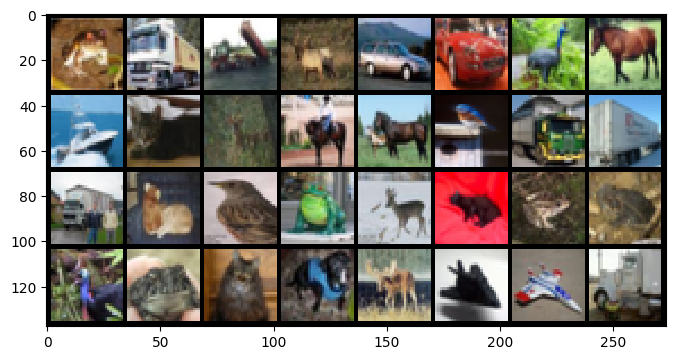

In [8]:
trainset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=32,
)
# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img, _ = next(iter(loader))
img_grid = make_grid(img)

plt.figure(figsize = (8, 8))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')

In [9]:
def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> float:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum

Now let's define the training and evaluation functions, which will be called later to train different models.

In [10]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        epoch: int,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    train_loss = []
    acc = 0.
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute metrics
        acc += compute_accuracy(output, target)
        train_loss.append(loss.item())

        if batch_idx % log_interval == 0 or batch_idx >= len(train_loader):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_acc = 100. * acc / len(train_loader.dataset)

    return np.mean(train_loss), avg_acc

In [11]:
@torch.no_grad() # decorator: avoid computing gradients
def eval_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        criterion: torch.nn.functional,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()

    test_loss = 0
    acc = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        output = network(data)

        # Apply the loss criterion and accumulate the loss
        test_loss += criterion(output, target).item()

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)

    test_loss /= len(test_loader)
    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [12]:
def train_net(
        network: torch.nn.Module,
        train_loader: torch.utils.data.DataLoader,
        eval_loader: torch.utils.data.DataLoader,
        optimizer: torch.optim,
        num_epochs: int,
        plot: bool=True,
        ) -> Dict[str, List[float]]:

    """ Function that trains and evals a network for num_epochs,
      showing the plot of losses and accs and returning them.
    """
    tr_losses = []
    tr_accs = []
    te_losses = []
    te_accs = []

    network.to(device)
    criterion = nn.NLLLoss(reduction='mean')

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc = train_epoch(train_loader, network, optimizer, criterion, epoch, hparams["log_interval"])
        te_loss, te_acc = eval_epoch(eval_loader, network, criterion)
        te_losses.append(te_loss)
        te_accs.append(te_acc)
        tr_losses.append(tr_loss)
        tr_accs.append(tr_acc)
    rets = {'tr_losses':tr_losses, 'te_losses':te_losses,
          'tr_accs':tr_accs, 'te_accs':te_accs}
    if plot:
        plt.figure(figsize=(10, 8))
        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('NLLLoss')
        plt.plot(tr_losses, label='train')
        plt.plot(te_losses, label='eval')
        plt.legend()
        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('Eval Accuracy [%]')
        plt.plot(tr_accs, label='train')
        plt.plot(te_accs, label='eval')
        plt.legend()
    return rets

We now define a `ConvBlock` layer that is composed by a convolution, a relu and the possibility to do a striding > 1. If we `stride > 1`, as commented in the previous lab about `CNN` classification, we perform a spatial decimation (hence we downsample the feature map resolution). This increases speed, reduces memory usage and condenses spatial features into non-spatial-but-abstract ones.

In [13]:
class ConvBlock(nn.Module):

    def __init__(
            self,
            num_inp_channels: int,
            num_out_fmaps: int,
            kernel_size: int,
            stride: int=1,
            ) -> None:

        super().__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.conv = nn.Conv2d(
            in_channels=num_inp_channels,
            out_channels=num_out_fmaps,
            kernel_size=(kernel_size, kernel_size),
            stride=(stride, stride),
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        P_ = self.kernel_size // 2
        if self.stride > 1:
            P = (P_ - 1, P_, P_  - 1, P_ )
        else:
            P = (P_, P_, P_, P_)
        x = self.conv(nn.functional.pad(x, P, mode='constant'))
        return self.relu(x)

We now define a helper function that tells us the amount of parameters contained in our model. This will help us understand possible issues of our design in terms of model magnitude.

In [14]:
def get_nn_nparams(net: torch.nn.Module) -> int:
  """
  Function that returns all parameters regardless of the require_grad value.
  https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
  """
  return sum([torch.numel(p) for p in list(net.parameters())])

### Our Model Design

We will work with a `CNN` for obvious reasons: image data. In this case note that our number of input channels are 3 because CIFAR has RGB format, not greyscale as with MNIST. Also, we define a deep network with 2 convolutional layers and a simple `MLP` on top that builds the classifier.

In [15]:
class BigNet(nn.Module):

    def __init__(self) -> None:

        super().__init__()
        self.conv1 = ConvBlock(
            num_inp_channels=3,
            num_out_fmaps=512,
            kernel_size=3,
            stride=4)

        self.conv2 = ConvBlock(
            num_inp_channels=512,
            num_out_fmaps=1024,
            kernel_size=3,
            stride=4)

        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=1024 * 2 * 2,
                out_features=1024
            ),
            nn.ReLU(inplace=True),
            nn.Linear(
                in_features=1024,
                out_features=hparams['num_classes']
            ),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        bsz, nch, height, width = x.shape
        x = x.reshape(bsz, -1)
        y = self.mlp(x)
        return y

In [16]:
bignet = BigNet()
# let's check the num of params
nparams = get_nn_nparams(bignet)
print('BigNet number of params: ', nparams)
optimizer = torch.optim.Adam(bignet.parameters(), lr=hparams['learning_rate'])

BigNet number of params:  8939530


Our model has approximately 9M params, not bad honestly (but not as large as many models nowadays). Nonetheless, it will serve our purpose to see the mismatching fit between train and eval sets.

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.636222

Test set: Average loss: 1.6379, Accuracy: 3947/10000 (39%)

Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.407164

Test set: Average loss: 1.5085, Accuracy: 4477/10000 (45%)

Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.434526

Test set: Average loss: 1.4559, Accuracy: 4666/10000 (47%)

Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.212609

Test set: Average loss: 1.4279, Accuracy: 4822/10000 (48%)

Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.311253

Test set: Average loss: 1.4756, Accuracy: 4820/10000 (48%)

Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.051251

Test set: Average loss: 1.4779, Accuracy: 4960/10000 (50%)

Train Epoch: 7 [10000/10000 (100%)]	Loss: 0.713758

Test set: Average loss: 1.5383, Accuracy: 4986/10000 (50%)

Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.597496

Test set: Average loss: 1.6217, Accuracy: 5033/10000 (50%)

Train Epoch: 9 [10000/10000 (100%)]	Loss: 0.520475

Test set: Average loss: 1.7780, Accuracy: 4892/10000

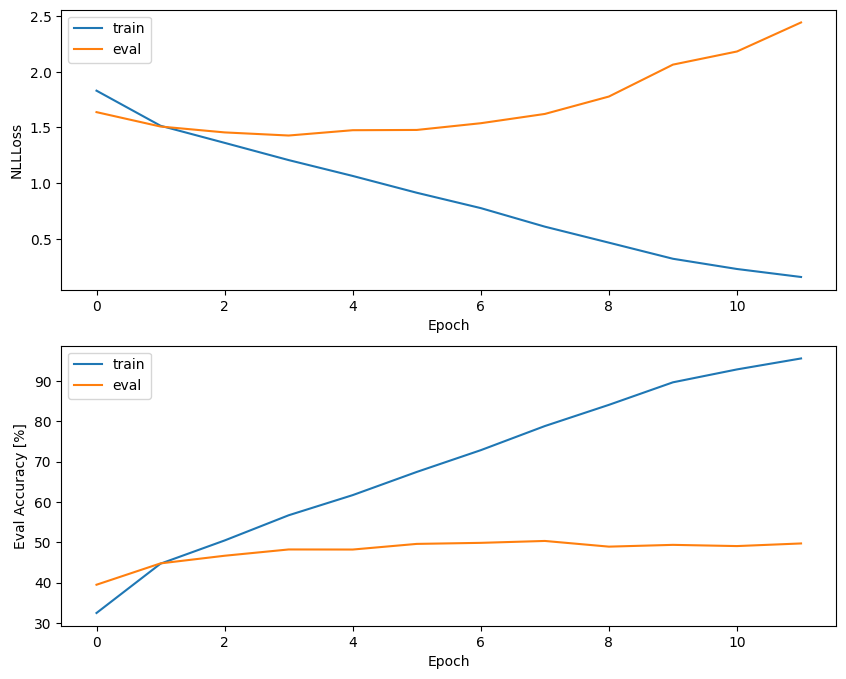

In [17]:
bigmodel_log = train_net(bignet, train_loader, test_loader, optimizer, hparams['num_epochs'])

The blue lines reflect the training loss and accuracy, while the orange lines are the evaluation (or validaton) loss and accuracy. Note that your own results may vary slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can leverage to mitigate overfitting

## Overfitting and underfitting

When training networks, we can notice that the performance of our model on the validation data would always peak after a few epochs and would then start degrading, i.e. our model would quickly start to overfit to the training data. Overfitting happens in every single machine learning problem. Learning how to deal with overfitting is essential to mastering machine learning.

The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of course, but you do not control generalization; you can only adjust the model based on its training data.

At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on test data. While this is happening, your model is said to be under-fit: there is still progress to be made; the network hasn't yet modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data.

To prevent a model from learning misleading or irrelevant patterns found in the training data, the best solution is of course to get more training data. A model trained on more data will naturally generalize better. When that is no longer possible, the next best solution is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to store. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called regularization. Let's review some of the most common regularization techniques, and let's apply them in practice to improve our model.

## Fighting overfitting

### Reducing the network's size

The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, **but the real challenge is generalization, not fitting**.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that **you should be using models that have enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources**. There is a compromise to be found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the right model size for your data.

Let's try to reduce our original network size with the following design:

In [18]:
class SmallNet(BigNet):

    def __init__(self) -> None:
        super().__init__()
        self.conv1 = ConvBlock(num_inp_channels=3, num_out_fmaps=128, kernel_size=3, stride=4)
        self.conv2 = ConvBlock(num_inp_channels=128, num_out_fmaps=256, kernel_size=3, stride=4)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=256 * 2 * 2, out_features=512),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=512, out_features=hparams['num_classes']),
            nn.LogSoftmax(dim=-1)
        )


In [19]:
smallnet = SmallNet()
# let's check the num of params
nparams = get_nn_nparams(smallnet)
print('SmallNet number of params: ', nparams)
optimizer = torch.optim.Adam(smallnet.parameters(), lr=hparams['learning_rate'])

SmallNet number of params:  828682


Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.544240

Test set: Average loss: 1.6803, Accuracy: 3884/10000 (39%)

Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.478339

Test set: Average loss: 1.5604, Accuracy: 4307/10000 (43%)

Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.374163

Test set: Average loss: 1.5068, Accuracy: 4584/10000 (46%)

Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.262829

Test set: Average loss: 1.4323, Accuracy: 4762/10000 (48%)

Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.477725

Test set: Average loss: 1.4441, Accuracy: 4870/10000 (49%)

Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.056763

Test set: Average loss: 1.4409, Accuracy: 4846/10000 (48%)

Train Epoch: 7 [10000/10000 (100%)]	Loss: 0.861246

Test set: Average loss: 1.4842, Accuracy: 4938/10000 (49%)

Train Epoch: 8 [10000/10000 (100%)]	Loss: 1.077250

Test set: Average loss: 1.5150, Accuracy: 5000/10000 (50%)

Train Epoch: 9 [10000/10000 (100%)]	Loss: 0.754045

Test set: Average loss: 1.5810, Accuracy: 4918/10000

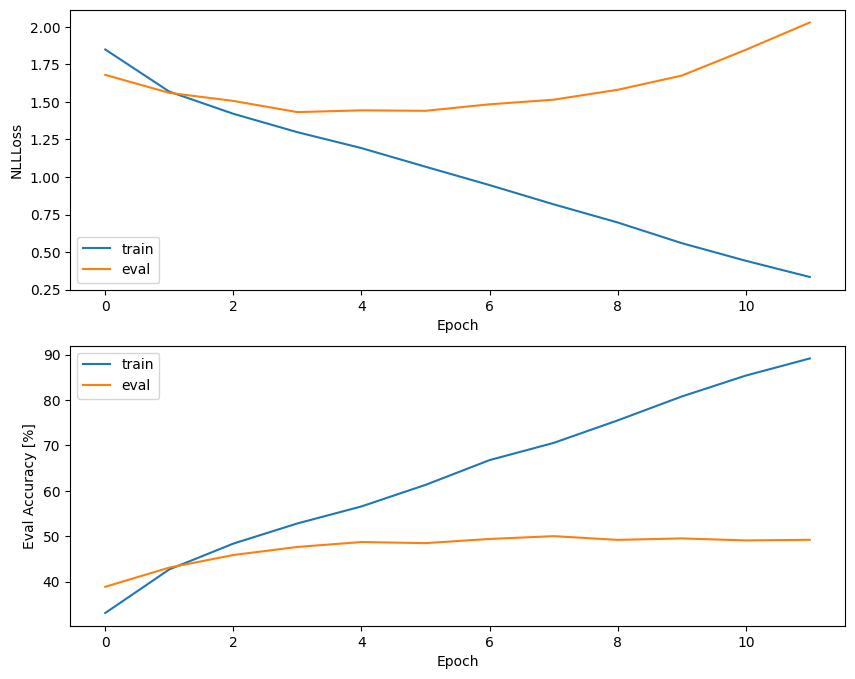

In [20]:
smallmodel_log = train_net(smallnet, train_loader, test_loader, optimizer, hparams['num_epochs'])

Let's plot the overlay of both networks.

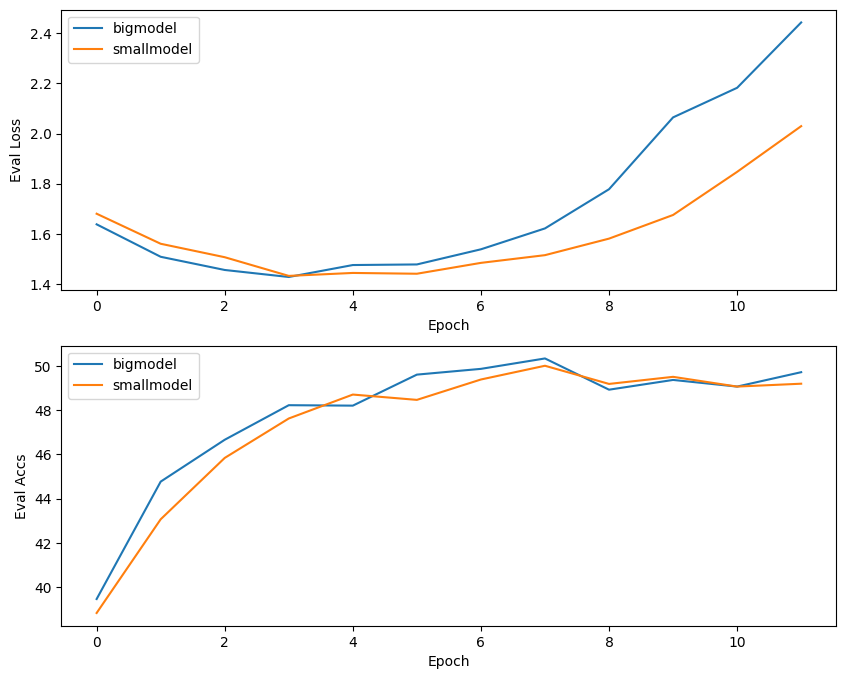

In [21]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bigmodel_log['te_losses'], label='bigmodel')
plt.plot(smallmodel_log['te_losses'], label='smallmodel')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(bigmodel_log['te_accs'], label='bigmodel')
plt.plot(smallmodel_log['te_accs'], label='smallmodel')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend()

As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance degrades much more slowly once it starts overfitting. In terms of accuracy, however, there is not much difference, and can even get a bit worse (depending on the seed). In general, reducing the network size is a viable strategy but might not be a good one, as we might be impeding a needed set of parameters by the model that we can instead "guide" to learn in a better way. In other words, reducing the model size can lead to capacity limitation, so that the model overfits slowly but reaches worse quotas. On the other hand, regularizing the big model might also slow down overfitting appearance, and reach better quotas than both the small model and the big non-regularized one.

##Exercise 1: Adding L2 weight regularization

You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.


**TODO:** In PyTorch, L2 weight regularization is added by controling the weight decay argument in the optimizer once this is built. Check the docs about the `Adam` optimizer and add build a `BigNet` where a `weight_decay` of 0.001 is applied (https://pytorch.org/docs/stable/optim.html#torch.optim.Adam). Then, train the model following the `train_net` function call, returning the value to the `bigmodel_l2_log` dictionary.

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.639232

Test set: Average loss: 1.6203, Accuracy: 4117/10000 (41%)

Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.513342

Test set: Average loss: 1.5134, Accuracy: 4432/10000 (44%)

Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.371771

Test set: Average loss: 1.4717, Accuracy: 4573/10000 (46%)

Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.233579

Test set: Average loss: 1.4308, Accuracy: 4745/10000 (47%)

Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.148503

Test set: Average loss: 1.4351, Accuracy: 4828/10000 (48%)

Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.340455

Test set: Average loss: 1.4220, Accuracy: 4899/10000 (49%)

Train Epoch: 7 [10000/10000 (100%)]	Loss: 1.006998

Test set: Average loss: 1.4221, Accuracy: 5074/10000 (51%)

Train Epoch: 8 [10000/10000 (100%)]	Loss: 0.929804

Test set: Average loss: 1.4701, Accuracy: 4967/10000 (50%)

Train Epoch: 9 [10000/10000 (100%)]	Loss: 0.903720

Test set: Average loss: 1.4745, Accuracy: 5057/10000

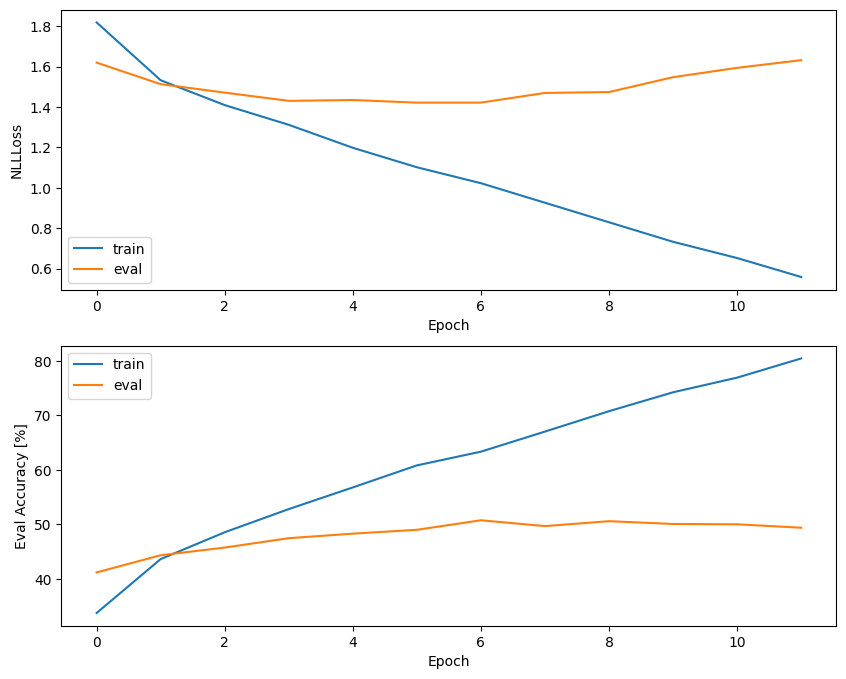

In [28]:
# TODO
bignet = BigNet()
optimizer = torch.optim.Adam(bignet.parameters(), lr=0.001, weight_decay=0.001)
bigmodel_l2_log = train_net(bignet, train_loader, test_loader, optimizer, hparams['num_epochs'])

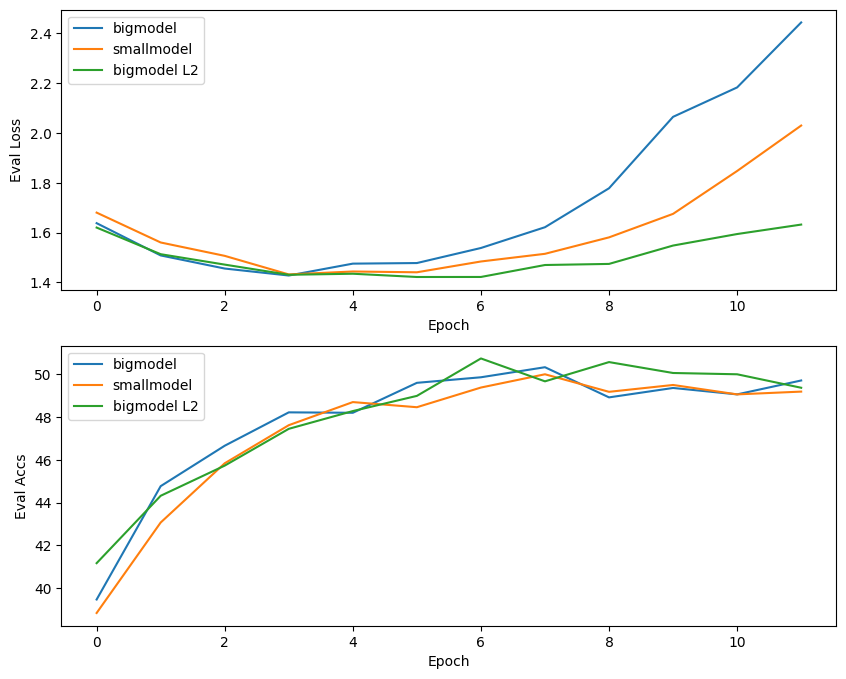

In [29]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bigmodel_log['te_losses'], label='bigmodel')
plt.plot(smallmodel_log['te_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_losses'], label='bigmodel L2')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.legend()
plt.subplot(2,1,2)
plt.plot(bigmodel_log['te_accs'], label='bigmodel')
plt.plot(smallmodel_log['te_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_accs'], label='bigmodel L2')
plt.xlabel('Epoch')
plt.ylabel('Eval Accs')
plt.legend()

As you can see, the model with L2 regularization (green) has become much more resistant to overfitting than the other two previous models (big and small). Actually, its robustness to overfitting is even better than that of the small model without regularization!

## Exercise 2: Adding dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among other things, by a fraud prevention mechanism used by banks -- in his own words: "I went to my bank. The tellers kept changing and I asked one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting".

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

**TODO:** In PyTorch you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before it, e.g.:

`nn.Dropout(0.5)`. Make a `BigNetDropout` class that has the same network structure as in `BigNet`, and contains dropouts after each `ConvBlock` and in the middle of the `mlp` sub-network. The class has to accept an argument `dropout` that controls the amount of `Dropout` of the aforementioned layers.

In [31]:
class BigNetDropout(nn.Module):

    def __init__(self, dropout: float) -> None:
        super().__init__()

        self.conv1 = ConvBlock(
            num_inp_channels=3,
            num_out_fmaps=512,
            kernel_size=3,
            stride=4)

        self.dropout_conv1 = nn.Dropout(dropout)

        self.conv2 = ConvBlock(
            num_inp_channels=512,
            num_out_fmaps=1024,
            kernel_size=3,
            stride=4)

        self.dropout_conv2 = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(
                in_features=1024 * 2 * 2,
                out_features=1024
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(
                in_features=1024,
                out_features=hparams['num_classes']
            ),
            nn.LogSoftmax(dim=-1)
        )



    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.dropout_conv1(x)
        x = self.conv2(x)
        x = self.dropout_conv2(x)
        bsz, nch, height, width = x.shape
        x = x.reshape(bsz, -1)
        y = self.mlp(x)
        return y

**TODO:** Once the dropout model is defined, build an instance of it and train it, storing its results in `bigmodel_dout_log`. Use the dropout factor defined below.

Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.832745

Test set: Average loss: 1.6895, Accuracy: 3915/10000 (39%)

Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.631974

Test set: Average loss: 1.5718, Accuracy: 4228/10000 (42%)

Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.431518

Test set: Average loss: 1.5176, Accuracy: 4471/10000 (45%)

Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.467372

Test set: Average loss: 1.4759, Accuracy: 4623/10000 (46%)

Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.550417

Test set: Average loss: 1.4640, Accuracy: 4681/10000 (47%)

Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.293260

Test set: Average loss: 1.4527, Accuracy: 4728/10000 (47%)

Train Epoch: 7 [10000/10000 (100%)]	Loss: 1.335698

Test set: Average loss: 1.4156, Accuracy: 4840/10000 (48%)

Train Epoch: 8 [10000/10000 (100%)]	Loss: 1.414139

Test set: Average loss: 1.4088, Accuracy: 4926/10000 (49%)

Train Epoch: 9 [10000/10000 (100%)]	Loss: 1.395334

Test set: Average loss: 1.4108, Accuracy: 4914/10000

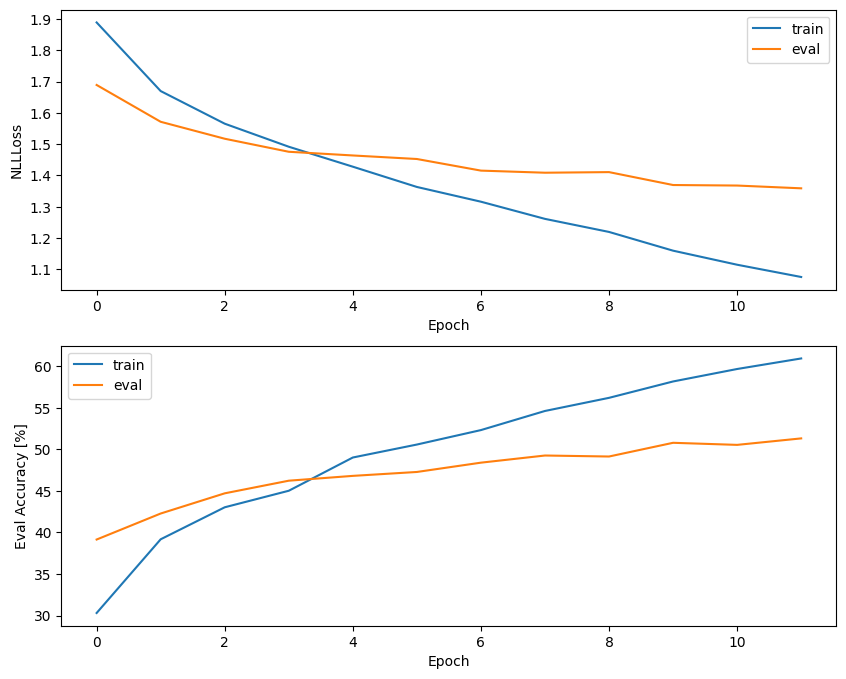

In [33]:
dropout = 0.5
# TODO
bignet = BigNetDropout(dropout)
optimizer = torch.optim.Adam(bignet.parameters(), lr=0.001)
bigmodel_dout_log = train_net(bignet, train_loader, test_loader, optimizer, hparams['num_epochs'])

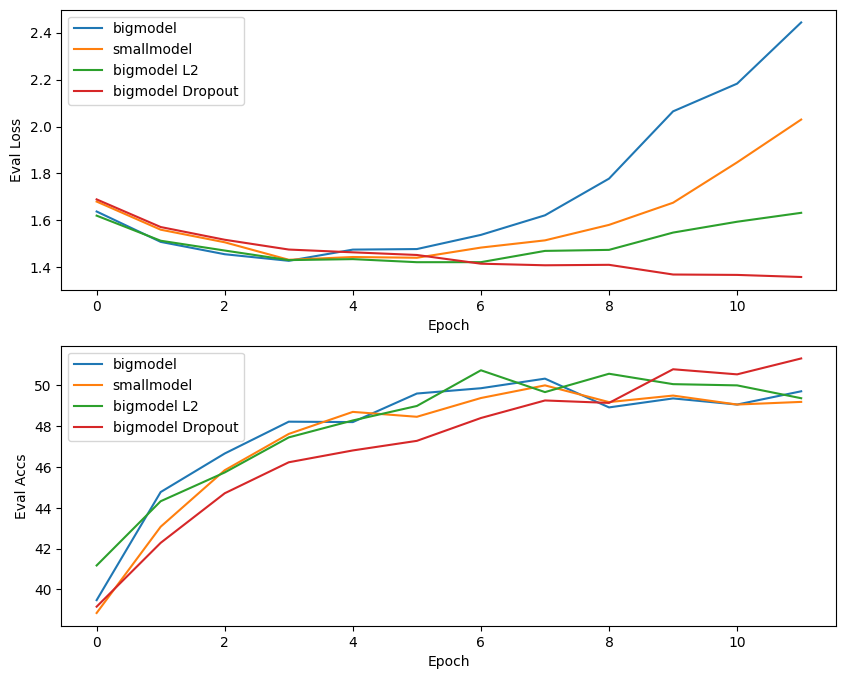

In [34]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bigmodel_log['te_losses'], label='bigmodel')
plt.plot(smallmodel_log['te_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_losses'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_losses'], label='bigmodel Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bigmodel_log['te_accs'], label='bigmodel')
plt.plot(smallmodel_log['te_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['te_accs'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['te_accs'], label='bigmodel Dropout')
plt.legend()
plt.xlabel('Epoch')
_ = plt.ylabel('Eval Accs')

We effectively reduced a lot the overfitting, and we cannot even notice it appearing anymore at least for the first 12 epochs. It also seems to yield a better trend in the evaluation accuracy, that seems to have an uprising trend. Something interesting to see, though, is the performance of training losses and accuracy, too...


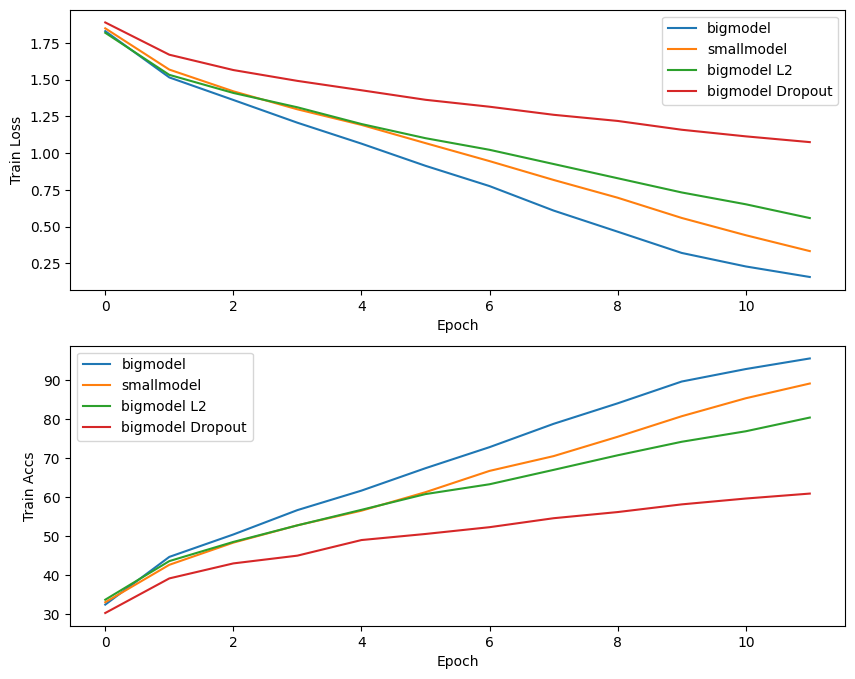

In [35]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bigmodel_log['tr_losses'], label='bigmodel')
plt.plot(smallmodel_log['tr_losses'], label='smallmodel')
plt.plot(bigmodel_l2_log['tr_losses'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['tr_losses'], label='bigmodel Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.subplot(2,1,2)
plt.plot(bigmodel_log['tr_accs'], label='bigmodel')
plt.plot(smallmodel_log['tr_accs'], label='smallmodel')
plt.plot(bigmodel_l2_log['tr_accs'], label='bigmodel L2')
plt.plot(bigmodel_dout_log['tr_accs'], label='bigmodel Dropout')
plt.legend()
plt.xlabel('Epoch')
_ = plt.ylabel('Train Accs')

WHOA! So it looks like the dropout model does really badly. In fact, there is a decreasing performance trend for both loss and accuracy for each ragularization method we introduced. Well, actually this is what we wanted to achieve: our model has to be as good in training as it is in validation.

**Important Note:** Once we close the gap between training and validation, then we can tune our model to improve on both simultanously. We could for instance put more conv layers or change the striding factors to less aggressive ones (e.g. 2 instead of 4). We could also add residual connections (something to see in advanced deep material). We could be using batch normalization layers. And we could do plenty of other stuff. But importantly, we could also **POUR IN MORE DATA**.

## Exercise 3: Grand Finale

**Train the Big Model with Dropout on the whole CIFAR10 Dataset**, and then check the overlayed evaluation plots for the BigModel, the BigModel with Dropout, and this new BigModel with Dropout on the Big Trainset. To make the exercise follow the steps:

1. Defining the CIFAR dataset per se in training mode (look at the beginning of the notebook), but do NOT trim the `.data` and `.targets` lists.
2. Make the `DataLoader` out of the dataset.
3. Build the big network as shown before, with its optimizer, and call the training routine shown above, storing the results in the `bigmodel_dout_log` dictionary.

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [10000/10000 (100%)]	Loss: 1.892751

Test set: Average loss: 1.7547, Accuracy: 3552/10000 (36%)

Train Epoch: 2 [10000/10000 (100%)]	Loss: 1.640610

Test set: Average loss: 1.5646, Accuracy: 4272/10000 (43%)

Train Epoch: 3 [10000/10000 (100%)]	Loss: 1.485023

Test set: Average loss: 1.5097, Accuracy: 4556/10000 (46%)

Train Epoch: 4 [10000/10000 (100%)]	Loss: 1.390359

Test set: Average loss: 1.4765, Accuracy: 4629/10000 (46%)

Train Epoch: 5 [10000/10000 (100%)]	Loss: 1.515530

Test set: Average loss: 1.4225, Accuracy: 4803/10000 (48%)

Train Epoch: 6 [10000/10000 (100%)]	Loss: 1.358413

Test set: Average loss: 1.4039, Accuracy: 4913/10000 (49%)

Train Epoch: 7 [10000/10000 (100%)]	Loss: 1.282841

Test set: Average loss: 1.4160, Accuracy: 4887/10000 (49%)

Train Epoch: 8 [10000/10000 (100%)]	Loss: 1.472194

Test set: Average loss: 1.3662, Accuracy: 5033/10000 (50%)

Train Epoch: 9 [10000/10000 

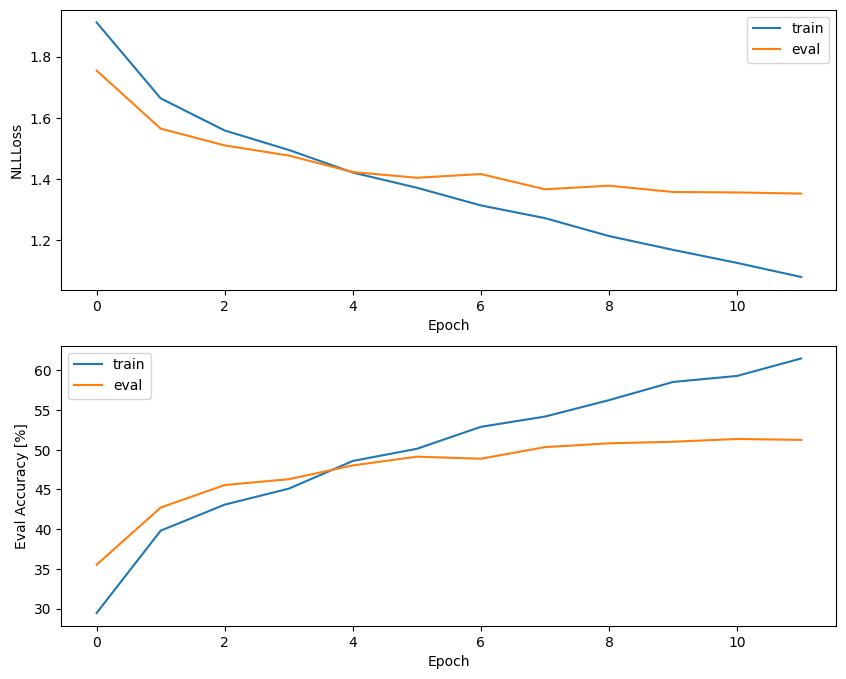

In [36]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset initializations

trainset = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform
)

evalset = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform
)

# Pick only the first 10k samples
trainset.data = trainset.data[:10000]
trainset.targets = trainset.targets[:10000]


# Dataloders initialization

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=evalset,
    batch_size=hparams['val_batch_size'],
    shuffle=False,
    drop_last=True,
)

# TODO: Load the whole CIFAR10
big_trainset = trainset

# TODO: Create a DataLoader
big_loader = torch.utils.data.DataLoader(
    dataset=big_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

# TODO: Build the big network with dropout and train it
dropout = 0.5
bignet = BigNetDropout(dropout)
optimizer = torch.optim.Adam(bignet.parameters(), lr=0.001)
bigmodel_bigtrainset_dout_log = train_net(bignet, train_loader, test_loader, optimizer, hparams['num_epochs'])

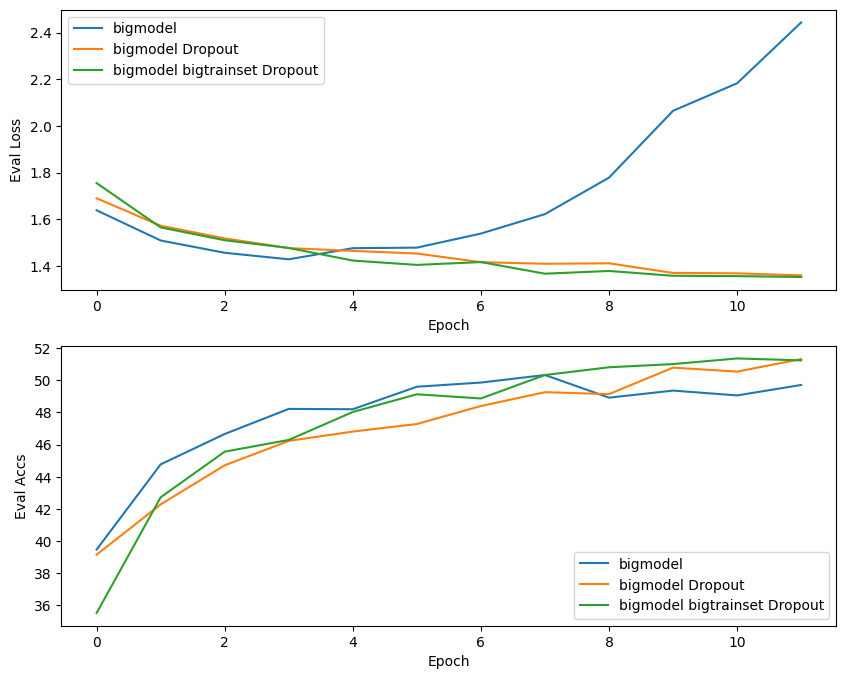

In [37]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(bigmodel_log['te_losses'], label='bigmodel')
plt.plot(bigmodel_dout_log['te_losses'], label='bigmodel Dropout')
plt.plot(bigmodel_bigtrainset_dout_log['te_losses'], label='bigmodel bigtrainset Dropout')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')
plt.subplot(2,1,2)
plt.plot(bigmodel_log['te_accs'], label='bigmodel')
plt.plot(bigmodel_dout_log['te_accs'], label='bigmodel Dropout')
plt.plot(bigmodel_bigtrainset_dout_log['te_accs'], label='bigmodel bigtrainset Dropout')
plt.legend()
plt.xlabel('Epoch')
_ = plt.ylabel('Eval Accs')

To recap... here the most common ways to prevent overfitting in neural networks:

* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.
* Getting more training data.
